# FluRS - A Library for Streaming Recommendation Algorithms

This notebook provides code snippets and supplemental information for [Takuya Kitazawa](https://takuti.me/about/)'s talk at [EuroSciPy 2017](https://www.euroscipy.org/2017/).

First and foremost, let's import the fundamental "SciPy" tools here:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import numpy.linalg as ln

## Past: The era of user-item matrix

At the beginning, consider the following tiny user-item matrix:

In [2]:
# 5 users * 6 items
R = np.array([[5, 0, 1, 1, 0, 2],
              [0, 2, 0, 4, 0, 4],
              [4, 5, 0, 1, 1, 2],
              [0, 0, 3, 5, 2, 0],
              [2, 0, 1, 0, 4, 4]])

### Collaborative Filtering (CF; k-Nearest-Neighbors)

- Compute similarities between users and items
- Recommend based on the users who have the same taste

In [3]:
def similarity(x, y):
    return np.inner(x, y) / (ln.norm(x, ord=2) * ln.norm(y, ord=2))

In [4]:
similarity(R[0], R[1])  # user a <-> user b

0.35921060405354982

In [5]:
similarity(R[0], R[2])  # user a <-> user c

0.65495314632780777

We can infer that, for user **a**, user **c** has more similar taste thatn user **b**.

### Singular Value Decomposition (SVD)

- Fill missing values in the original matrix
- Recommend based on the estimated values

In [6]:
U, s, V = ln.svd(R, full_matrices=False)

In [7]:
# represent user/item characteristics in a lower dimensional space
k = 2

np.dot(np.dot(U[:, :k], np.diag(s[:k])), V[:k, :])  # estimated user-item matrix

array([[ 3.19741238,  1.98064059,  0.19763307,  0.50430074,  1.04148574,
         2.47123826],
       [ 1.20450954,  1.18625722,  1.50361641,  3.5812116 ,  1.61569345,
         2.37803076],
       [ 4.36792826,  2.68465163,  0.20157659,  0.52659617,  1.36419993,
         3.30665072],
       [-0.94009727,  0.07701659,  2.08296828,  4.93223799,  1.52652414,
         1.44132726],
       [ 2.67985286,  1.80342544,  0.63125085,  1.52750202,  1.27145836,
         2.54266834]])

Since missing values in the original matrix has been filled, the valus can be used to predict how a user likely to interests with an item.

### Matrix Factorization (MF)

- Improve SVD's feasibility and performance
- Meaningless "zero"s are completely ignored

In [8]:
n_user, n_item = R.shape

# represent user/item characteristics in a lower dimensional space
k = 2

# gess random user/item factors
P = np.random.rand(n_user, k)
Q = np.random.rand(n_item, k)

In [9]:
for user in range(n_user):
    for item in range(n_item):
        if R[user, item] == 0:  # ignore zeros
            continue

        p, q = P[user], Q[item]

        err = R[user, item] - np.inner(p, q)  # estimation error

        # adjust factors based on the estimation error
        # yes, it's gradient descent!
        # `0.1` is learning rate, and `0.01` is regularization parameter
        next_p = p - 0.1 * (-2. * (err * q - 0.01 * p))
        next_q = q - 0.1 * (-2. * (err * p - 0.01 * q))
        
        P[user], Q[user] = next_p, next_q

In [10]:
np.dot(P, Q.T)  # estimated user-item matrix

array([[ 1.92446381,  2.73360623,  1.27773199,  1.37483882,  2.81655903,
         1.71409787],
       [ 1.84394518,  2.56750642,  1.24881087,  1.3169581 ,  2.72251093,
         1.6542269 ],
       [ 2.67019761,  3.70145911,  1.8162267 ,  1.90695881,  3.95003891,
         2.39925182],
       [ 2.52771656,  3.42530305,  1.7566224 ,  1.80465948,  3.77544498,
         2.28923944],
       [ 2.48612615,  3.31255891,  1.75446764,  1.7745757 ,  3.7392629 ,
         2.26448566]])

## Present: Streamed complex user-item data

- Particularly focus on **implicit feedback recommendation**
    - Create model based on "actions" such as buy, watch, listen and click, rather than "rating value"
- **FluRS** provides an easy and structured way to implement such recommender

### Unified data representation

In order to provide unified interface to a wide variety of real-world data, FluRS requests you to define `user`, `item` and `event`, components which are fed into recommender system, as follows:

In [12]:
!pip install flurs

The directory '/Users/ivanmatis/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/ivanmatis/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
  Running setup.py install for mmh3 ... done
  Running setup.py install for flurs ... done


In [13]:
from flurs.data.entity import User, Item, Event

In [42]:
# define a user with index 0
user = User(0)
user4 = User(4)

# define an item with index 0
item = Item(0)

# interaction between a user and item
# e.g., a user bought an item
event = Event(user, item)
event4 = Event(user4, item)

For more complex input, `user` and `item` can be defined with its features in a vector form. For instance, user's demographics such as age and sex, and item properties like category and price are considered as the "features."

Moreover, you can set contextual information (e.g., time, location, distance) to `event`.

In [15]:
# define a user with his/her feature set
user = User(0, feature=np.array([0, 0, 1]))

# define an item with its properties
item = Item(0, feature=np.array([2, 1, 1]))

# interaction between a user and item under a certain context
event = Event(user, item, context=np.array([0, 4, 0]))

### Same interface regardless of internal algorithms

It is certainly the scikit-learn's way! We mostly hit `fit` and `predict` on scikit-learn.

To give an example, let us launch `Popular` recommender which simply returns the most popular items over every users. This kind of naive (but it works!) recommendation logic is called "non-personalized recommender systems."

First, define additional set of users and items as follows:

In [43]:
user_a = User(0, feature=np.array([0, 0, 1]))
user_b = User(1, feature=np.array([1, 0, 1]))
user_c = User(2, feature=np.array([1, 3, 1]))
user_d = User(5, feature=np.array([1, 2, 1]))

In [17]:
item_a = Item(0, feature=np.array([2, 1, 1]))
item_b = Item(1, feature=np.array([0, 2, 1]))

Second, create a new recommendation instance and initialize it:

In [18]:
from flurs.baseline.popular import Popular

In [44]:
recommender = Popular()
recommender.initialize()

Next, in a mannar of **dependency injection**, register potential user and item to the recommender:

In [45]:
recommender.register(user_a)
recommender.register(user_b)
recommender.register(user_c)
recommender.register(user_d)

In [46]:
recommender.register(item_a)
recommender.register(item_b)

Now, we are ready to launch recommendation! Let's feed a couple of events to the recommender:

In [48]:
recommender.update(Event(user_a, item_b))
recommender.update(Event(user_b, item_b))
recommender.update(Event(user_a, item_a))
recommender.update(Event(user_d, item_a))

Obviously, `item_b` (i.e., item indexed by `1`) is the most popular, so the item should be recommended to `user_c` in the following case:

In [49]:
# specify target user and list of item candidates' indices
candicates = np.array([0, 1])  # item a and b
recommender.recommend(user_c, candicates)  # => (sorted item indices, scores)

(array([1, 0]), array([ 4.,  3.]))

Note that the score indicates the frequency of corresponding item on the `Popular` recommender.

Even if you choose a different recommender, you use it in the same mannar. Following code tries to launch incremental variant of matrix factorization on the previous data:

In [24]:
from flurs.recommender.mf import MFRecommender

In [50]:
# initialize a recommendation instance
recommender = MFRecommender(k=40)
recommender.initialize()

# register users and items
recommender.register(user_a)
recommender.register(user_b)
recommender.register(user_c)
recommender.register(user_d)

recommender.register(item_a)
recommender.register(item_b)

# feed some events
recommender.update(Event(user_a, item_b))
recommender.update(Event(user_b, item_b))
recommender.update(Event(user_a, item_a))

# make recommendation to `user_c`
candidates = np.array([0, 1])
recommended_items, scores = recommender.recommend(user_c, candidates)
recommended_items

array([1, 0])

Internally, FluRS separates recommender-specific functionality from core algorithm implementation. So, implementing a new recommendation algorithm on the package is not so complicated.

### Incremental evaluation scheme

FluRS enables you to evaluate recommendation engine in a streaming environment by following to "**[test-then-learn](http://link.springer.com/chapter/10.1007/978-3-319-08786-3_41)**" shecme. In short, the evaluation framework first trains recommendation model by using initial 30% of samples in a batch fashion. After that, for the remaining 70% of samples, recommender sequentially launches top-N recommendation and check if observed item is correctly included in a recommendation list.

For instance, let us initialize a `UserKNNRecommender` (i.e., CF recommender):

In [27]:
from flurs.recommender.user_knn import UserKNNRecommender

In [28]:
recommender = MFRecommender(k=3)  # consider 3 nearest-neighbors
recommender.initialize()

In order to launch evaluation on a little bit more large-scale data, here we define 10000 users and items, and register them to the recommender:

In [29]:
users = [User(u) for u in range(10000)]
for user in users:
    recommender.register(user)

In [30]:
items = [Item(i) for i in range(10000)]
for item in items:
    recommender.register(item)

Next, the recommender is injected to `Evaluator` as:

In [31]:
from flurs.evaluator import Evaluator

In [32]:
evaluator = Evaluator(recommender)

Based on the 10000 users and items, randomly create 1000 events:

In [33]:
random_interactions = zip(np.random.choice(users, 1000), np.random.choice(items, 1000))
events = [Event(u, i) for u, i in random_interactions]

For the initial 30% of events, launch batch training on a recommender, and following 20% of samples are used to validate the accuracy of recommendation as a result batch training:

In [34]:
evaluator.fit(events[:300], events[300:500])

Define a window with a certain size, and sequentially evaluate the remaining 70% of events:

In [35]:
from collections import deque
window = deque(maxlen=200)

In [36]:
accuracy = []
for top_score, rank, recommend_time, update_time in evaluator.evaluate(events[300:]):
    window.append(int(rank < 10))  # consider top-10 recommendation
    accuracy.append(sum(window) / len(window))

Plotting variation of the accuracy of recommendation is insightful, isn't it? :)

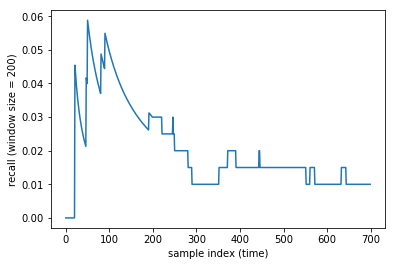

In [37]:
plt.plot(accuracy)
plt.xlabel('sample index (time)')
plt.ylabel('recall (window size = 200)')

### Feature-based recommendation

In the above examples, even if we create `User` and `Item` instances with `feature`, the classical recommenders cannot handle the auxiliary information. So, let us try alternative feature-based recommender. In particular, `FMRecommender` is a recommender based on one of the most famous recommendation techniques named [Factorization Machines](http://dl.acm.org/citation.cfm?id=2168771) (FMs).

We need to pass the number of dimensions of feature vector as `p=8`. In this case, our feature vector will have 8 different elements (3 from user, 3 from item, and 2 from context).

In [38]:
from flurs.recommender.fm import FMRecommender

In [39]:
# initialize a recommendation instance
recommender = FMRecommender(p=8, k=2)
recommender.initialize()

User/item registration and incremental updating are completely same as what we did before (but don't forget to put `context=...` to define an `Event` instance):

In [40]:
# register users and items
recommender.register(user_a)
recommender.register(user_b)
recommender.register(user_c)

recommender.register(item_a)
recommender.register(item_b)

# feed some events
recommender.update(Event(user_a, item_b, context=np.array([1, 1])))
recommender.update(Event(user_b, item_b, context=np.array([0, 2])))
recommender.update(Event(user_a, item_a, context=np.array([1, 3])))

Finally, context-aware recommendation is launched as:

In [41]:
# make recommendation to `user_c`
candidates = np.array([0, 1])
recommended_items, scores = recommender.recommend(user_c, candidates, context=np.array([0, 4]))  # pass current context
recommended_items

array([0, 1])

## References

### Algorithms

FluRS currently supports the following recommendation algorithms:

- Incremental Collaborative Filtering: `UserKNN`
  - M. Pepagelis et al. **Incremental Collaborative Filtering for Highly-Scalable Recommendation Algorithms**. In *Foundations of Intelligent Systems*, pp. 553–561, Springer Berlin Heidelberg, 2005.
- Incremental Matrix Factorization: `MF`
  - J. Vinagre et al. **[Fast Incremental Matrix Factorization for Recommendation with Positive-only ](http://link.springer.com/chapter/10.1007/978-3-319-08786-3_41)**. In *Proc. of UMAP 2014*, pp. 459–470, July 2014.
- Incremental Matrix Factorization with BPR optimization: `BPRMF`
  - S. Rendle et al. **BPR: Bayesian Personalized Ranking from Implicit Feedback**. In *Proc. of UAI 2009*, pp. 452–461, June 2009.
- Incremental Factorization Machines: `FM`
  - T. Kitazawa. **[Incremental Factorization Machines for Persistently Cold-Starting Online Item Recommendation](https://arxiv.org/abs/1607.02858)**. arXiv:1607.02858 [cs.LG], July 2016.
- Matrix Sketching: `OnlineSketch
  - T. Kitazawa. **[Sketching Dynamic User-Item Interactions for Online Item Recommendation](http://dl.acm.org/citation.cfm?id=3022152)**. In *Proc. of CHIIR 2017*, March 2017.

### OSS for recommender systems

- [Surprise](http://surpriselib.com/) (Python)
- [fastFM](http://ibayer.github.io/fastFM/) (Python)
- [Implicit](http://implicit.readthedocs.io/en/latest/) (Python)
- [MyMediaLite](http://www.mymedialite.net/) (C#)
- [LibRec](https://www.librec.net/) (Java)
- [LensKit](http://lenskit.org/) (Java)

If you are interested in recommendation on Apache Hadoop, Hive, Spark:

- [Apache Mahout](http://mahout.apache.org/)
- [Apache Hivemall](https://github.com/apache/incubator-hivemall)
- [Spark MLlib](https://spark.apache.org/mllib/)